In [ ]:
import pandas as pd
import seaborn as sns
import utils
import ETL

df = pd.read_csv("/work/data/train.csv")
df2 = pd.read_csv("/work/data/test.csv")

df = utils.title_engineering(df)
df = utils.encoding(df)
df = utils.imputing(df)

df2 = utils.title_engineering(df2)
df2 = utils.encoding(df2)
df2 = utils.imputing(df2)

age_df = df[~df["Age"].isnull()]
print(len(age_df))
age_df2 = df2[~df2["Age"].isnull()]
print(len(age_df2))
age_df =  pd.concat([age_df, age_df2])
print(len(age_df))
age_df.head()

891
418
1309


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0.0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,B96 B98,2.0,1.0
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,0.0,1.0
2,3,1.0,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,G6,2.0,1.0
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,2.0,1.0
4,5,0.0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,2.0,1.0


<AxesSubplot:>

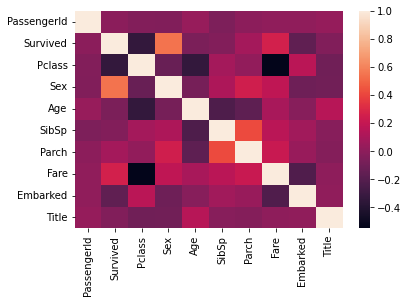

In [ ]:
corr = df.corr()
sns.heatmap(corr,  xticklabels=corr.columns,  yticklabels=corr.columns)

In [ ]:
corr["Age"].sort_values(ascending=False)


Age            1.000000
Title          0.148415
Fare           0.096688
PassengerId    0.034212
Embarked      -0.018754
Survived      -0.064910
Sex           -0.081163
Parch         -0.172482
SibSp         -0.233296
Pclass        -0.339898
Name: Age, dtype: float64

In [ ]:
from sklearn.model_selection import train_test_split

X = age_df[utils.Maps.age_predictors]
y = age_df['Age']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.4, shuffle=True, stratify=age_df["Sex"])

In [ ]:
import xgboost as xgb
import numpy as np
import optuna
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from optuna.samplers import TPESampler
from xgboost import XGBRegressor
from optuna.integration import XGBoostPruningCallback
from sklearn.model_selection import RepeatedKFold
from optuna import create_study

def objective(
    trial,
    X,
    y,
    random_state=22,
    n_splits=3,
    n_repeats=2,
    n_jobs=1,
    early_stopping_rounds=100,
):
    # XGBoost parameters
    params = {
        "verbosity": 0,  # 0 (silent) - 3 (debug)
        "objective": "reg:squarederror",
        "n_estimators": 10000,
        "max_depth": trial.suggest_int("max_depth", 4, 12),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.00001, 0.01),
        "colsample_bytree": trial.suggest_loguniform("colsample_bytree", 0.2, 0.6),
        "subsample": trial.suggest_loguniform("subsample", 0.4, 0.8),
        "alpha": trial.suggest_loguniform("alpha", 0.01, 10.0),
        "lambda": trial.suggest_loguniform("lambda", 1e-8, 10.0),
        "gamma": trial.suggest_loguniform("gamma", 1e-8, 10.0),
        "min_child_weight": trial.suggest_loguniform("min_child_weight", 10, 1000),
        "seed": random_state,
        "n_jobs": n_jobs,
    }

    model = XGBRegressor(**params)
    pruning_callback = XGBoostPruningCallback(trial, "validation_0-rmse")
    rkf = RepeatedKFold(
        n_splits=n_splits, n_repeats=n_repeats, random_state=random_state
    )
    X_values = X.values
    y_values = y.values
    y_pred = np.zeros_like(y_values)
    for train_index, test_index in rkf.split(X_values):
        X_A, X_B = X_values[train_index, :], X_values[test_index, :]
        y_A, y_B = y_values[train_index], y_values[test_index]
        model.fit(
            X_A,
            y_A,
            eval_set=[(X_B, y_B)],
            eval_metric="rmse",
            verbose=0,
            callbacks=[pruning_callback],
            early_stopping_rounds=early_stopping_rounds,
        )
        y_pred[test_index] += model.predict(X_B)
    y_pred /= n_repeats
    return np.sqrt(mean_squared_error(y_train, y_pred))

/shared-libs/python3.9/py/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
sampler = TPESampler(seed=124, multivariate=True)
study = create_study(direction="minimize", sampler=sampler)
study.optimize(
    lambda trial: objective(
        trial,
        X_train,
        y_train,
        random_state=124,
        n_splits=10,
        n_repeats=1,
        n_jobs=12,
        early_stopping_rounds=100,
    ),
    n_trials=2,
    n_jobs=1,
)

# display params
hp = study.best_params
for key, value in hp.items():
    print(f"{key:>20s} : {value}")
print(f"{'best objective value':>20s} : {study.best_value}")

  warnings.warn(
/root/venv/lib/python3.9/site-packages/optuna/trial/_trial.py:462: UserWarning: The reported value is ignored because this `step` 4836 is already reported.
  warnings.warn(
/root/venv/lib/python3.9/site-packages/optuna/trial/_trial.py:462: UserWarning: The reported value is ignored because this `step` 4837 is already reported.
  warnings.warn(
/root/venv/lib/python3.9/site-packages/optuna/trial/_trial.py:462: UserWarning: The reported value is ignored because this `step` 4838 is already reported.
  warnings.warn(
/root/venv/lib/python3.9/site-packages/optuna/trial/_trial.py:462: UserWarning: The reported value is ignored because this `step` 4839 is already reported.
  warnings.warn(
/root/venv/lib/python3.9/site-packages/optuna/trial/_trial.py:462: UserWarning: The reported value is ignored because this `step` 4840 is already reported.
  warnings.warn(
/root/venv/lib/python3.9/site-packages/optuna/trial/_trial.py:462: UserWarning: The reported value is ignored because 

In [ ]:
hp["verbosity"] = 0
hp["objective"] = "reg:squarederror"
hp["n_estimators"] = 10000
hp["seed"] = 124
hp["n_jobs"] = 12
model = XGBRegressor(**hp)
rkf = RepeatedKFold(n_splits=10, n_repeats=1, random_state=124)
X_values = X_train.values
y_values = y_train.values
y_pred = np.zeros_like(y_test.values)
for train_index, test_index in rkf.split(X_values):
    X_A, X_B = X_values[train_index, :], X_values[test_index, :]
    y_A, y_B = y_values[train_index], y_values[test_index]
    model.fit(
        X_A,
        y_A,
        eval_set=[(X_B, y_B)],
        eval_metric="rmse",
        early_stopping_rounds=100,
        verbose=0,
    )
    y_pred += model.predict(X_test.values)
y_pred /= 1 * 10

/root/venv/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/root/venv/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


In [ ]:
rmse = mean_squared_error(y_pred, y_test, squared=False)
rmse

12.160120784023457

In [ ]:
import pickle
with open('./age_model', 'wb') as files:
    pickle.dump(model, files)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=34b6ad67-9899-4609-8c36-e96f39426d07' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>